In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
%matplotlib notebook
import timeit
start_time=timeit.default_timer()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/pmbc3k.h5ad'

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.0.4 anndata==0.6.1 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/'
untreated = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
untreated.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
untreated.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
print(untreated.shape)

... reading from cache file ./cache/home-ehamilton-ProjectSummer2018-GRCh38-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
(6617, 33694)


In [3]:
untreated.var_names_make_unique()

In [4]:
sc.pp.filter_cells(untreated, min_genes=200)
sc.pp.filter_genes(untreated, min_cells=3)

In [5]:
mito_genes = [name for name in untreated.var_names if name.startswith('MT-')]
untreated.obs['percent_mito']=np.sum( untreated[:, mito_genes].X, axis=1).A1 / np.sum(untreated.X, axis=1).A1
untreated.obs['n_counts']= untreated.X.sum(axis=1).A1

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


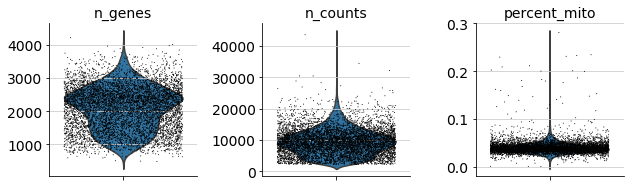

In [6]:
sc.pl.violin(untreated, ['n_genes','n_counts','percent_mito'], jitter=0.4, multi_panel=True)

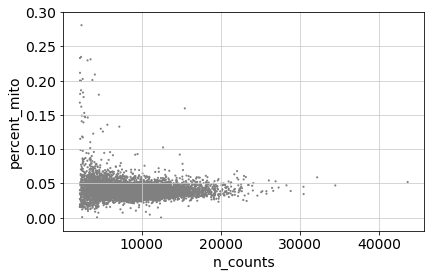

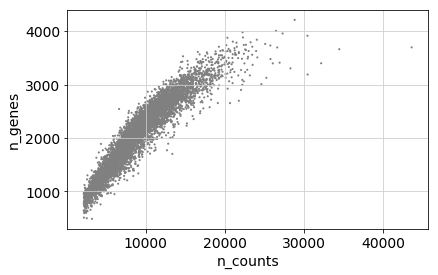

In [7]:
sc.pl.scatter(untreated, x='n_counts',y='percent_mito')
sc.pl.scatter(untreated, x='n_counts',y='n_genes')

In [8]:
untreated = untreated[untreated.obs['n_genes'] < 4000, :]
untreated = untreated[untreated.obs['percent_mito'] < 0.1, :]
print(untreated.shape)

(6578, 15740)


In [9]:
untreated.raw = sc.pp.log1p(untreated, copy=True)

In [10]:
print(untreated.raw)

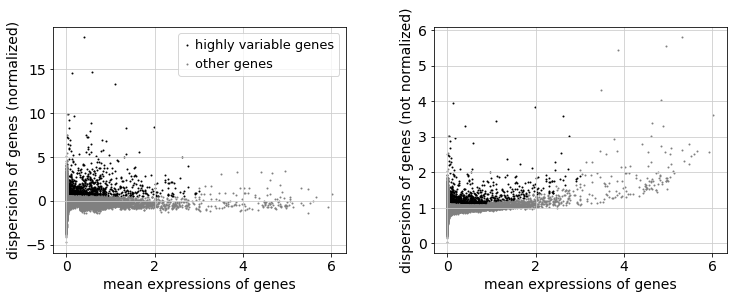

In [11]:
sc.pp.normalize_per_cell(untreated, counts_per_cell_after=20000)
filter_result = sc.pp.filter_genes_dispersion(untreated.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [12]:
untreated = untreated[:, filter_result.gene_subset]

In [13]:
print(untreated.X)

  (0, 0)	2.9664788
  (0, 2)	11.865915
  (0, 4)	2.9664788
  (0, 7)	2.9664788
  (0, 16)	2.9664788
  (0, 19)	2.9664788
  (0, 23)	2.9664788
  (0, 24)	8.899437
  (0, 28)	2.9664788
  (0, 34)	2.9664788
  (0, 35)	20.765352
  (0, 37)	2.9664788
  (0, 38)	2.9664788
  (0, 41)	2.9664788
  (0, 54)	8.899437
  (0, 73)	2.9664788
  (0, 94)	2.9664788
  (0, 102)	2.9664788
  (0, 109)	2.9664788
  (0, 120)	5.9329576
  (0, 136)	2.9664788
  (0, 137)	2.9664788
  (0, 139)	2.9664788
  (0, 142)	5.9329576
  (0, 144)	2.9664788
  :	:
  (6577, 1678)	2.531325
  (6577, 1692)	17.719276
  (6577, 1715)	7.593975
  (6577, 1716)	2.531325
  (6577, 1719)	2.531325
  (6577, 1732)	2.531325
  (6577, 1736)	2.531325
  (6577, 1737)	12.656626
  (6577, 1743)	5.06265
  (6577, 1744)	2.531325
  (6577, 1755)	2.531325
  (6577, 1757)	15.18795
  (6577, 1759)	5.06265
  (6577, 1773)	15.18795
  (6577, 1774)	2.531325
  (6577, 1789)	12.656626
  (6577, 1791)	17.719276
  (6577, 1799)	5.06265
  (6577, 1805)	2.531325
  (6577, 1817)	2.531325
  (6577, 18

In [14]:
sc.pp.log1p(untreated)

In [15]:
sc.pp.scale(untreated, max_value=10)

In [16]:
untreated.write(results_file)

In [17]:
sc.tl.pca(untreated)

In [18]:
untreated.obsm['X_pca'].shape

(6578, 50)

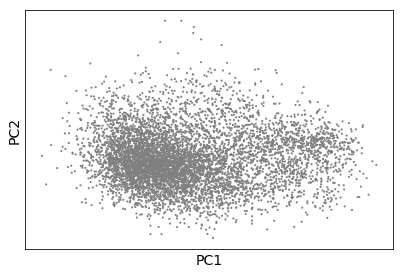

In [19]:
sc.pl.pca_scatter(untreated)

In [20]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs


In [21]:
af = AffinityPropagation(preference=-32000).fit(untreated.X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_


In [22]:
n_clusters_ = len(cluster_centers_indices)
n_clusters_

5

In [23]:
import matplotlib.pyplot as plt
from itertools import cycle

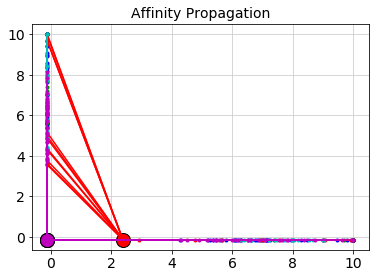

In [24]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = untreated.X[cluster_centers_indices[k]]
    plt.plot(untreated.X[class_members, 0], untreated.X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in untreated.X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation')
plt.show()

In [25]:
print(labels)

[2 3 0 ... 0 1 0]


In [26]:
df = pd.DataFrame(labels)
df.columns=['Affinity']
df

,Affinity
0,2
1,3
2,0
3,0
4,0
5,4
6,4
7,0
8,0
9,3


In [27]:
icantbelievethatworked = pd.merge(untreated.obs, untreated.obs)

In [28]:
W = pd.concat([icantbelievethatworked, df], axis=1, join='inner')

In [110]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/'
outfile = outpath + 'AffinityDownsizedCellListNew.csv'
W.to_csv(outfile, sep='\t')

In [29]:
import random
x=random.sample(range(6577),3000)

In [30]:
untreated_subset3K = untreated[x, :]

In [31]:
untreated_subset3K.var_names_make_unique()

In [32]:
sc.tl.pca(untreated_subset3K)

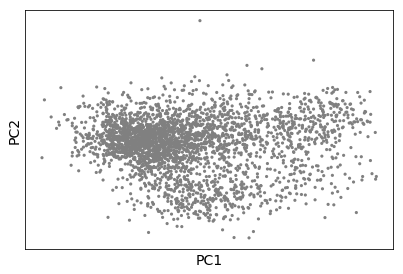

In [33]:
sc.pl.pca_scatter(untreated_subset3K)

In [34]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs


In [38]:
af = AffinityPropagation(preference=-11000).fit(untreated_subset3K.X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_


In [39]:
n_clusters_ = len(cluster_centers_indices)
n_clusters_

5

In [40]:
import matplotlib.pyplot as plt
from itertools import cycle

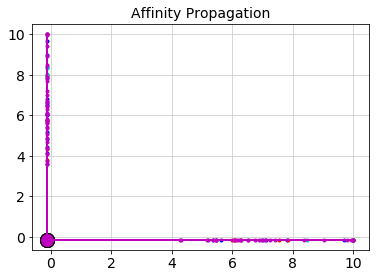

In [41]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = untreated_subset3K.X[cluster_centers_indices[k]]
    plt.plot(untreated_subset3K.X[class_members, 0], untreated_subset3K.X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in untreated_subset3K.X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation')
plt.show()

In [42]:
print(labels)

[0 1 4 ... 0 0 4]


In [43]:
df = pd.DataFrame(labels)
df.columns=['Affinity']
df

,Affinity
0,0
1,1
2,4
3,4
4,4
5,4
6,4
7,0
8,0
9,3


In [44]:
icantbelievethatworked3K = pd.merge(untreated_subset3K.obs, untreated_subset3K.obs)

In [45]:
Affinity3K = pd.concat([icantbelievethatworked, df], axis=1, join='inner')

In [46]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-23/Subset 3000/'
outfile = outpath + 'AffinityDownsizedCellList3K_5.csv'
Affinity3K.to_csv(outfile, sep='\t')

In [47]:
x=random.sample(range(6577),1000)

In [48]:
untreated_subset1K = untreated[x, :]

In [49]:
untreated_subset1K.var_names_make_unique()

In [50]:
sc.tl.pca(untreated_subset1K)

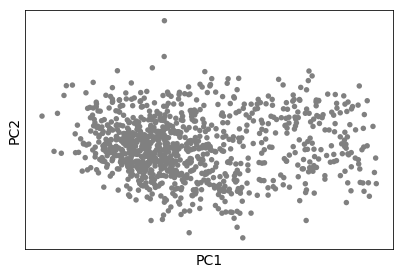

In [51]:
sc.pl.pca_scatter(untreated_subset1K)

In [52]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs


In [53]:
af = AffinityPropagation(preference=-5400).fit(untreated_subset1K.X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_


In [54]:
n_clusters_ = len(cluster_centers_indices)
n_clusters_

5

In [55]:
import matplotlib.pyplot as plt
from itertools import cycle

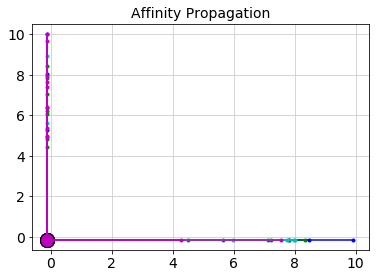

In [56]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = untreated_subset1K.X[cluster_centers_indices[k]]
    plt.plot(untreated_subset1K.X[class_members, 0], untreated_subset1K.X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in untreated_subset1K.X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation')
plt.show()

In [57]:
print(labels)

[3 3 3 3 4 3 1 4 0 4 3 4 0 2 3 1 3 2 4 3 0 1 3 1 1 2 1 4 0 4 3 3 4 4 4 1 1
 1 2 2 1 4 1 3 4 3 3 3 4 1 0 1 3 4 4 3 3 0 3 4 3 0 1 1 4 4 4 3 3 4 0 3 1 2
 3 4 2 3 4 3 3 3 1 1 3 4 3 1 1 0 1 3 2 2 4 4 1 0 3 4 3 4 3 3 4 1 3 1 3 0 1
 1 4 3 4 1 1 3 2 3 4 0 3 2 4 1 3 0 3 4 1 3 1 1 2 3 3 4 3 4 0 3 4 2 3 3 1 2
 3 3 3 3 3 2 2 2 3 3 3 3 4 0 4 0 3 3 3 3 4 1 1 3 1 3 1 4 3 2 2 3 4 2 3 1 3
 3 2 4 3 2 3 0 4 4 2 2 2 4 3 3 4 4 1 3 3 4 3 3 2 1 4 4 4 3 1 3 1 3 2 3 3 4
 3 3 4 3 0 3 2 2 0 2 4 0 3 2 3 3 1 3 4 4 2 1 1 1 4 4 4 3 3 1 4 1 2 2 3 4 4
 4 4 3 3 3 2 1 1 3 3 4 3 3 3 3 3 2 2 3 3 4 3 3 3 3 4 3 1 2 4 3 3 1 0 3 1 2
 2 2 2 3 0 3 1 0 4 2 0 1 2 0 2 2 3 3 2 4 4 4 4 0 3 3 4 3 3 3 3 2 0 0 1 4 0
 1 3 3 2 3 4 3 1 2 1 0 3 1 4 4 1 0 1 1 4 4 3 2 3 3 2 3 3 4 0 3 0 0 3 3 3 2
 2 1 0 1 3 2 4 2 3 1 4 4 4 0 4 3 2 0 2 4 3 3 1 3 3 3 4 0 0 1 0 2 3 3 1 1 3
 1 3 2 3 2 1 4 3 4 1 1 1 3 4 1 3 4 3 1 2 0 4 3 1 1 1 4 3 4 1 3 4 1 4 1 3 1
 2 4 4 3 3 3 3 2 4 1 3 3 4 3 4 3 4 2 3 4 2 3 3 0 0 3 0 4 3 3 4 3 3 2 1 3 4
 3 0 3 3 4 1 2 4 4 4 3 2 

In [58]:
df = pd.DataFrame(labels)
df.columns=['Affinity']
df

,Affinity
0,3
1,3
2,3
3,3
4,4
5,3
6,1
7,4
8,0
9,4


In [59]:
icantbelievethatworked1K = pd.merge(untreated_subset1K.obs, untreated_subset1K.obs)

In [60]:
Affinity1K = pd.concat([icantbelievethatworked, df], axis=1, join='inner')

In [61]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-23/Subset 1000/'
outfile = outpath + 'AffinityDownsizedCellList1K_5.csv'
Affinity1K.to_csv(outfile, sep='\t')

In [62]:
x=random.sample(range(6577),500)

In [63]:
untreated_subset500 = untreated[x, :]

In [64]:
untreated_subset500.var_names_make_unique()

In [65]:
sc.tl.pca(untreated_subset500)

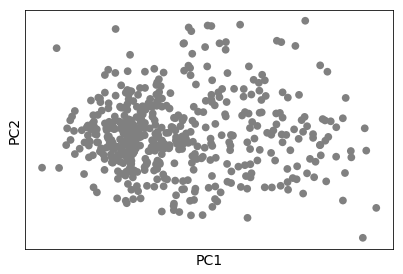

In [66]:
sc.pl.pca_scatter(untreated_subset500)

In [67]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs


In [72]:
af = AffinityPropagation(preference=-4000).fit(untreated_subset500.X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_


In [73]:
n_clusters_ = len(cluster_centers_indices)
n_clusters_

5

In [74]:
import matplotlib.pyplot as plt
from itertools import cycle

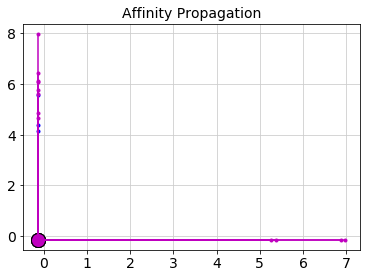

In [75]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = untreated_subset500.X[cluster_centers_indices[k]]
    plt.plot(untreated_subset500.X[class_members, 0], untreated_subset500.X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in untreated_subset500.X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation')
plt.show()

In [76]:
print(labels)

[4 4 4 4 4 4 0 0 0 4 4 0 0 0 4 4 0 4 0 4 0 4 4 4 4 4 4 4 0 4 0 4 4 4 0 4 4
 0 0 0 0 4 4 4 0 4 0 0 4 4 4 4 0 4 0 0 4 4 0 0 4 4 4 4 0 0 0 0 4 4 0 4 4 0
 4 4 0 4 4 4 4 4 4 4 0 0 0 0 4 0 4 4 0 0 0 0 4 0 0 0 0 4 0 0 0 4 0 0 0 4 4
 4 0 4 4 4 4 4 0 0 4 0 4 4 4 0 0 4 4 4 4 0 4 0 4 0 4 4 4 4 4 0 0 0 0 4 4 4
 4 0 0 4 0 4 0 0 4 4 0 4 4 0 4 0 0 4 0 4 0 4 4 4 4 4 4 4 4 0 4 1 0 4 4 4 4
 4 0 4 0 4 4 0 0 4 4 0 0 4 0 4 0 4 4 4 0 4 0 4 4 4 4 4 4 0 4 0 4 4 4 4 4 4
 0 4 0 0 0 0 4 4 0 4 0 0 4 4 0 4 0 4 0 0 4 0 4 4 0 4 4 4 4 4 4 4 4 0 4 0 4
 4 4 0 4 0 0 4 0 4 4 0 4 4 0 4 0 4 0 4 0 4 4 0 4 0 4 0 4 0 0 0 0 0 4 4 0 4
 4 4 4 0 4 2 4 4 4 3 4 4 4 4 0 4 0 4 4 0 0 4 0 0 0 4 0 0 0 4 0 4 4 4 4 0 4
 4 0 4 4 4 4 0 0 4 4 0 0 4 0 4 4 0 4 0 4 0 4 0 4 4 4 4 0 0 4 4 4 0 4 4 4 4
 4 4 4 0 0 0 4 4 4 4 0 4 0 4 4 0 0 4 0 4 0 4 4 0 0 4 0 4 4 4 4 4 0 4 0 4 4
 4 4 0 0 0 4 0 4 4 0 4 0 4 4 4 0 4 4 0 4 0 4 4 0 0 4 4 0 4 4 0 4 0 0 4 4 4
 4 4 4 4 0 4 0 4 0 0 4 4 4 0 0 4 0 4 4 0 4 0 4 4 4 0 4 4 0 4 4 4 0 4 4 4 4
 0 0 4 0 0 0 4 0 0 4 0 4 

In [77]:
df = pd.DataFrame(labels)
df.columns=['Affinity']
df

,Affinity
0,4
1,4
2,4
3,4
4,4
5,4
6,0
7,0
8,0
9,4


In [78]:
icantbelievethatworked500 = pd.merge(untreated_subset500.obs, untreated_subset500.obs)

In [79]:
Affinity500 = pd.concat([icantbelievethatworked, df], axis=1, join='inner')

In [80]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-23/Subset 500/'
outfile = outpath + 'AffinityDownsizedCellList500_5.csv'
Affinity500.to_csv(outfile, sep='\t')

In [81]:
x=random.sample(range(6577),300)

In [82]:
untreated_subset300 = untreated[x, :]

In [83]:
untreated_subset300.var_names_make_unique()

In [84]:
sc.tl.pca(untreated_subset300)

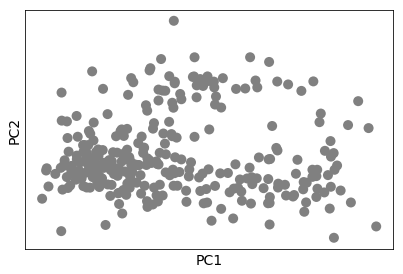

In [85]:
sc.pl.pca_scatter(untreated_subset300)

In [86]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs


In [101]:
af = AffinityPropagation(preference=-3750).fit(untreated_subset300.X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_


In [102]:
n_clusters_ = len(cluster_centers_indices)
n_clusters_

5

In [103]:
import matplotlib.pyplot as plt
from itertools import cycle

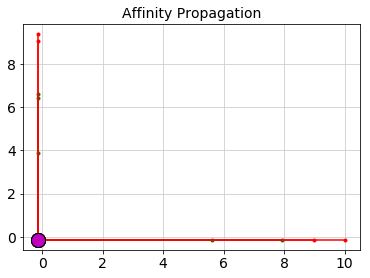

In [104]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = untreated_subset300.X[cluster_centers_indices[k]]
    plt.plot(untreated_subset300.X[class_members, 0], untreated_subset300.X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in untreated_subset300.X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation')
plt.show()

In [105]:
print(labels)

[1 1 2 2 1 1 1 1 1 1 2 2 1 1 1 1 1 2 2 2 2 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 2
 1 1 1 1 1 2 1 1 1 1 1 2 2 2 1 1 2 1 2 1 1 2 1 2 2 2 0 1 1 1 1 1 1 1 1 2 1
 2 2 1 2 2 1 2 2 2 1 2 1 1 2 1 2 2 2 1 2 2 1 1 1 1 2 1 2 1 1 2 2 1 1 2 1 2
 1 2 1 2 2 2 1 2 2 1 2 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1
 1 1 1 1 1 2 1 2 1 2 1 1 1 1 2 2 1 2 1 1 1 1 1 2 1 1 1 2 2 2 1 1 2 1 1 1 1
 1 1 1 1 2 1 1 2 2 2 1 1 1 1 1 2 2 2 2 1 2 1 1 1 1 1 1 1 2 1 2 2 2 1 2 2 2
 2 2 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 2 1 1 2 1 1 2 2 2 2 2 1 1 1
 2 1 1 1 1 2 1 1 1 2 1 1 2 2 1 3 1 1 2 2 1 2 1 2 1 1 1 1 1 1 1 2 1 2 1 2 4
 2 1 2 1]


In [106]:
df = pd.DataFrame(labels)
df.columns=['Affinity']
df

,Affinity
0,1
1,1
2,2
3,2
4,1
5,1
6,1
7,1
8,1
9,1


In [107]:
icantbelievethatworked300 = pd.merge(untreated_subset300.obs, untreated_subset300.obs)

In [108]:
Affinity300 = pd.concat([icantbelievethatworked, df], axis=1, join='inner')

In [109]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-23/Subset 300/'
outfile = outpath + 'AffinityDownsizedCellList300_5.csv'
Affinity300.to_csv(outfile, sep='\t')